<a href="https://colab.research.google.com/github/ndams55/Gaussian_Mixture_Model_AMMI_2023/blob/main/Gaussian_Mixture_Model_AMMI_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Librairies

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import math


<ipython-input-140-c8f7db8946fc>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Import Dataset

In [ ]:
iris = datasets.load_iris()
X = iris.data
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [ ]:
idx = np.random.permutation(X.shape[0])
X = X[idx]

## Modelling

### Implement **Gaussian density function**

Let us now implement the Gaussian density function. Remember that the gaussian density function looks like:

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{d/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}

Where:
*   d is the number of features of our training set
*   $\mathbf\Sigma$ and  $\mathbf\mu$ are the variance-covariance matrix and mean vector of the distribution




In [ ]:
def gaussian_df(x, mu, sigma):
  """
    gaussian_df(x,mu,sigma): It accepts three arguments, x: the dataset , mu: the mean vector, sigma: the covariance-veriance matrix.
    It returns: the probability for each feature in the dataset.
    """
  d = x.shape[1]
  X = x - mu

  res = np.diag((1.0/ ((2*np.pi)**(d/2) * (np.linalg.det(sigma))** 0.5)) * np.exp(-0.5 * np.dot(np.dot(X, np.linalg.inv(sigma)),X.T)))

  return res

### Implementation of EM Algorithm functions

__Step 01: Initialize mean, covariance, and weights__


In [ ]:
def initialize_clusters(data_set, num_clusters):
  """
  initialize_clusters(data_set, num_clusters): It accepts data_set, and the number of clusters.
  It usese the Kmeans centroid  as initialization for our gaussians means.
  It returns: a list of dictionaries, with each dictionaries with the keys of phi, mu, and covariance matrix.
  """
  clusters = [] #Initialize the cluster list.
  idx = np.arange(data_set.shape[0])
    
  kmeans = KMeans(num_clusters).fit(data_set)
  mu_k = kmeans.cluster_centers_ #Getting the Kmeans centroids for GMM mean.

  for i in range(num_clusters):
      clusters.append({
          'phi_j': 1.0 / num_clusters,
          'mu_j': mu_k[i],
          'cov_j': np.identity(data_set.shape[1], dtype=np.float64)
          })
      
  return clusters

**Step 02: Expectation Step (E step)**

In this step, we are computing the probability that the data belongs to a cluster j. Let us call $w_{j}^{(i)}$, the probability that the data point i belong to the cluster j. The expression of $w_{j}^{(i)}$ is given by:

\begin{equation}
\large
w_{j}^{(i)}= p{(z^{(i)} = j| x^{(i)}; \mathbf\phi, \mathbf\mu, \mathbf\Sigma)} = \frac {p{(x^{(i)}}|{z^{(i)}} = j;\mathbf\mu, \mathbf\Sigma)p{(z^{(i)}} = j; \mathbf\phi)}{\sum_{l=1}^K p{(x^{(i)}}|{z^{(i)}} = l;\mathbf\mu, \mathbf\Sigma) p{(z^{(i)}} = l; \mathbf\phi)}
\end{equation}


In [ ]:
def expectation_step(x, clusters):
  """This function compute the probability that the data belongs to a cluster k 
  inputs: - x : a data point; size = (n, d)
          - clusters: a list of clusters, 

  outputs: For each sample, The probability that this sample belongs to the class k; size =. (n, k) 
  """

  n, d = x.shape
  k = len(clusters)
  p = np.zeros((n,k))
  proba = np.zeros((n, 1))

  for j, cluster in enumerate(clusters):
    mu_j = cluster['mu_j'] 
    phi_j = cluster['phi_j']
    sig_j = cluster['cov_j']
    val = gaussian_df(x, mu_j, sig_j)*phi_j 
    p[:, j] = val # probability that each sample is belong to the class j
    
  proba = np.sum(p, axis = 1)
  p /= np.expand_dims(proba, axis = 1) 

  return proba, p


**Step 3: Maximization step (M step)**

Let us now implement the maximization step. Since $w_{j}^{(i)}$ is common to the expressions for $\phi_j$, $\mu_j$ and $\Sigma_j$, we can simply define:

In the maximization step, we update the parameters using:

\begin{equation}
\large
\phi_j=\dfrac {\sum_{i=1}^{n}w_{j}^{(i)}} n
\end{equation}


\begin{equation}
\large
\mu_j=\frac {\sum_{i=1}^n w_j^{(i)}\hspace{0.1cm} \mathbf x^{(i)}}{\sum_{i=1}^{n}w_{j}^{(i)}}
\end{equation}


\begin{equation}
\large
\Sigma_j=\frac {\sum_{i=1}^n w_j^{(i)}(\mathbf x^{(i)}-\mathbf\mu_j)(\mathbf x^{(i)}-\mathbf\mu_j)^T}{\sum_{i=1}^{n}w_{j}^{(i)}}
\end{equation}

In [ ]:
def maximization_step(data_set, clusters,prob_vector):
  """
  maximization_step(data_set, clusters,prob_vector): It accepts the data set, our cluster list, and prob_vector: from the expectation steps.
  It updates the model parameters.
  """
  num_rows = data_set.shape[0]
  for j, cluster in enumerate(clusters):
      weight_j = prob_vector[:,j].reshape(-1,1)
      sum_weight_j = np.sum(weight_j, axis=0)

      #Update the parameters
      phi_j = sum_weight_j / num_rows
      mu_j = np.sum(weight_j * data_set, axis=0) / sum_weight_j
      cov_j = (weight_j * (data_set - mu_j)).T @ (data_set - mu_j) / sum_weight_j
      
      #Modify the dictionary values
      cluster['phi_j'] = phi_j
      cluster['mu_j'] = mu_j
      cluster['cov_j'] = cov_j

### Compute the log likelihood of the model

Let us now determine the log-likelihood of the model. It is given by:

\begin{equation}
\large
l(\theta) = \sum_{i=1}^N\log p(\mathbf x^{(i)}; θ)=\sum_{i=1}^N\log\sum_{l=1}^k p{(x^{(i)}}|{z^{(i)}} = l;\mathbf\mu, \mathbf\Sigma) p{(z^{(i)}} = l; \mathbf\phi)
\end{equation}



In [ ]:
def likehood(proba):
  sample = np.log(proba) # This proba come from the expectation step
  return np.sum(sample, axis=0)

In [ ]:
def train(x, n_clusters, n_epochs):

  clusters = initialize_clusters(x, n_clusters)
  n, d = x.shape    
  scores = np.zeros((X.shape[0], n_clusters))
  losses = np.zeros((n_epochs, ))

  for i in range(0, n_epochs):

    clusters_copy = clusters.copy()  # we make a copy of our original cluster

    proba, prob_vector = expectation_step(x, clusters) # we compute the probability matrix
    maximization_step(x, clusters,prob_vector) #we update the parameters

    loss = likehood(proba)

    losses[i] = loss
    print('Epoch: ', i + 1, 'Likelihood: ', loss)

  scores = np.log(proba)
 
  return scores, losses, clusters_copy


## Implementation of GMM Class



In [ ]:
class GaussianMixture():

  def __init__(self, x, num_clusters):
    self.x_data = x
    self.shape = x.shape
    self.probas = None  #dim = (n,k) which is the matirx of For each sample, The probability that this sample belongs to the class k
    self.n_clusters = num_clusters
    self.clusters = None

  
  def multiv_gauss(self,mu,sigma):
    """
    multiv_gauss(x,mu,sigma): It accepts three arguments, x: the dataset , mu: the mean vector, sigma: the covariance-veriance matrix.
    It returns: the probability for each feature in the dataset.
    """

    d = self.x_data.shape[1]
    X = self.x_data - mu
    res = np.diag((1.0/ ((2*np.pi)**(d/2) * (np.linalg.det(sigma))** 0.5)) * np.exp(-0.5 * np.dot(np.dot(X, np.linalg.inv(sigma)),X.T)))

    return res


  def compute_likelihood(self, proba):
    sample = np.log(proba) # This proba come from the expectation step
    return np.sum(sample, axis=0), sample


  def initialize_clusters(self):
    """
    initialize_clusters(data_set, num_clusters): It accepts data_set, and the number of clusters.
    It usese the Kmeans centroid  as initialization for our gaussians means.
    It returns: a list of dictionaries, with each dictionaries with the keys of phi, mu, and covariance matrix.
    """
    self.clusters = [] #Initialize the cluster list.
    idx = np.arange(self.shape[0])
      
    kmeans = KMeans(self.n_clusters).fit(self.x_data)
    mu_k = kmeans.cluster_centers_ #Getting the Kmeans centroids for GMM mean.

    for i in range(self.n_clusters):
        self.clusters.append({
            'phi_j': 1.0 / self.n_clusters,
            'mu_j': mu_k[i],
            'cov_j': np.identity(self.shape[1], dtype=np.float64)
            })
        


  def expectation_step(self):
    """This function compute the probability that the data belongs to a cluster k 
    inputs: - x : a data point; size = (n, d)
            - clusters: a list of clusters, 

    outputs: For each sample, The probability that this sample belongs to the class k; size =. (n, k) 
    """
    n, d = self.shape
    k = len(self.clusters)
    self.probas = np.zeros((n,k))
    prob = np.zeros((n, 1))

    for j, cluster in enumerate(self.clusters):
      mu_j = cluster['mu_j'] 
      phi_j = cluster['phi_j']
      sig_j = cluster['cov_j']
      val = self.multiv_gauss( mu_j, sig_j)*phi_j 
      self.probas[:, j] = (phi_j * self.multiv_gauss( mu_j, sig_j)) # probability that each sample is belong to the class j
      
    prob = np.sum(self.probas, axis = 1)
    self.probas /= np.expand_dims(prob, axis = 1) 

    return prob



  def maximization_step(self):
    """
    maximization_step(data_set, clusters,prob_vector): It accepts the data set, our cluster list, and prob_vector: from the expectation steps.
    It updates the model parameters.
    """
    num_rows = self.shape[0]
    for j, cluster in enumerate(self.clusters):

        weight_j = self.probas[:,j].reshape(-1,1)
        sum_weight_j = np.sum(weight_j, axis=0)

        #Update the parameters
        phi_j = sum_weight_j / num_rows
        mu_j = np.sum(weight_j * self.x_data, axis=0) / sum_weight_j
        cov_j = (weight_j * (self.x_data - mu_j)).T @ (self.x_data - mu_j) / sum_weight_j

        #Modify the dictionary values
        cluster['phi_j'] = phi_j
        cluster['mu_j'] = mu_j
        cluster['cov_j'] = cov_j



  def train(self, n_epochs, tol):

    clusters = self.initialize_clusters()
    n, d = self.shape    
    losses = np.zeros((n_epochs, ))
    self.scores = np.zeros((X.shape[0], self.n_clusters))
    self.history = []

    for i in range(0, n_epochs):

      clusters_snapshot = []
        
        # This is just for our later use in the graphs
      for cluster in self.clusters:
        clusters_snapshot.append({
                'mu_j': cluster['mu_j'].copy(),
                'cov_j': cluster['cov_j'].copy()
            })
        self.history.append(clusters_snapshot)


      prob  = self.expectation_step() # we compute the probability matrix
      self.maximization_step() #we update the parameters

      loss, sample = self.compute_likelihood(prob)

      losses[i] = loss
      if abs(loss - losses[i-1]) <= tol:
        break


    loss = np.mean(losses)
    self.scores = np.log(self.probas)
    # self.AIC = 2*3*self.n_clusters - 2*loss  #n*loss + 2*3*self.n_clusters
    # self.BIC = -2 * loss + 2*math.log(n) * 3*self.n_clusters # BIC =k*ln(n)-2*ln(L)
  
    return losses, sample


## Determining the number of clusters

In [ ]:
def cluster_creation(x, start, end):
  """ This method helps to find the number of cluster using kMEANS in sklearn.
    Input: X : the dataset
          start, end: range of differents number of cluster

    Output: list of inertia; which measures how well the dataset was clustered by K-Means.
  """

  resl_list=[]
  for i in range(start, end + 1):
    kmeans = KMeans(i).fit(x)
    resl_list.append(kmeans.inertia_)  #append the inertia measured with K-Mean, K=i

  return resl_list

In [ ]:
result = cluster_creation(X,1,19)

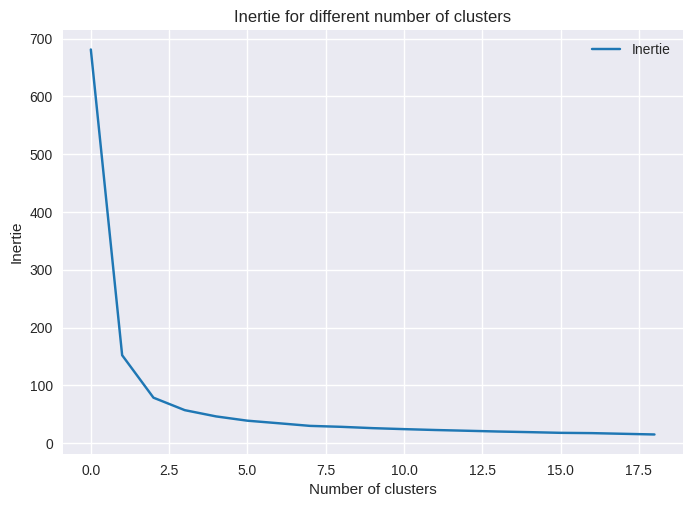

In [ ]:
x = np.arange(len(result))
#plt.grid()


plt.plot(x, result, color='tab:blue', label='Inertie')
plt.xticks()
plt.yticks()

plt.ylabel("Inertie")
plt.xlabel("Number of clusters")


plt.title("Inertie for different number of clusters")

plt.legend()

plt.show()

## Training the GMM model

In [ ]:
model = GaussianMixture(X, num_clusters= 3)

In [ ]:
losses, sample = model.train(n_epochs=15, tol = 10^-5)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


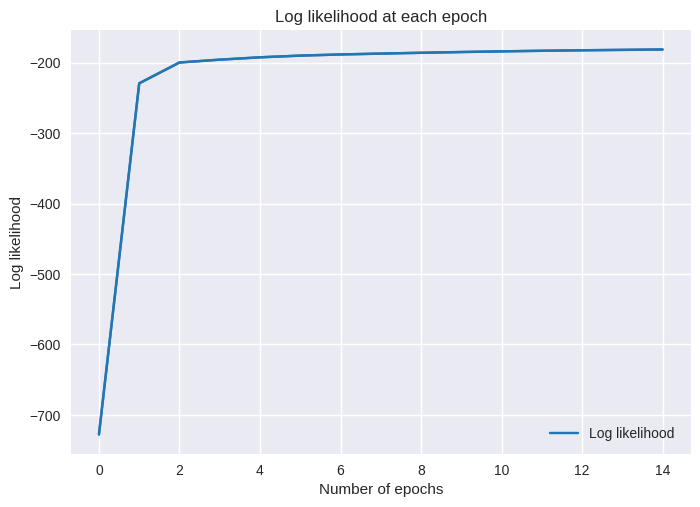

In [ ]:
plt.plot(losses)

x = np.arange(len(losses))
#plt.grid()


plt.plot(x, losses, color='tab:blue', label='Log likelihood ')
plt.xticks()
plt.yticks()

plt.ylabel("Log likelihood")
plt.xlabel("Number of epochs")


plt.title("Log likelihood at each epoch")

plt.legend()

plt.show()

## Plotting the differents data clusters formed



*   **Reference Tutorial :** [create_cluster_animation](https://rayblick.gitbooks.io/my-python-scrapbook/content/analysis/plotting/scatterplot_ellipse.html)



In [ ]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
from PIL import Image

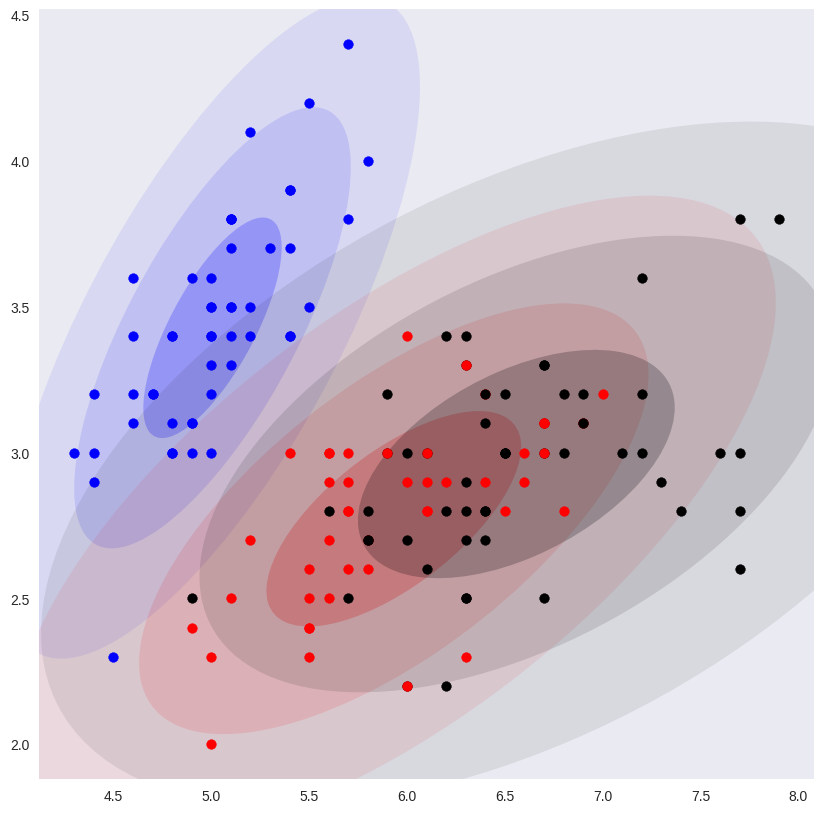

In [ ]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_j']
            cov = cluster['cov_j']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            #ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    plt.grid()
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, model.history , model.scores)

## Comparing with sklearn GaussianMixture model

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gmm = GaussianMixture(n_components=3, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_j'].tolist() for cluster in model.clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample.reshape(-1)[0:20])

Means by sklearn:
 [[6.54639415 2.94946365 5.48364578 1.98726565]
 [5.006      3.428      1.462      0.246     ]
 [5.9170732  2.77804839 4.20540364 1.29848217]]
Means by our implementation:
 [[5.006      3.428      1.462      0.246     ]
 [5.92770042 2.77587277 4.22337423 1.3059595 ]
 [6.55321361 2.95573794 5.50064603 1.99834809]]
Scores by sklearn:
 [-2.58855877 -2.12834347 -0.92934784 -3.8494936  -4.19338302  0.11508687
 -1.95910798  1.54721281  1.16051416 -0.47936329 -0.35343193 -3.497598
 -4.86118474 -2.57846637 -1.31138827  1.14436656  0.97699215 -1.27295641
 -1.97391054 -1.51788573]
Scores by our implementation:
 [-2.58862766 -2.1284841  -0.92939244 -3.73585273 -4.46527519  0.1151149
 -1.92857729  1.54729267  1.16057234 -0.64177007 -0.20024619 -3.46315451
 -4.77655979 -2.68936128 -1.30681472  1.14444614  0.9770596  -1.28177015
 -1.96085124 -1.51483573]


### Reference

*   **[Link ](https://github.com/ndams55/Gaussian_Mixture_Model_AMMI_2023.git)of our Github Repository** 



## When to use Gaussian mixture models:

1- Clusters are not fully separated. 

2- Need a probability that each point belongs to each cluster. 

3- You do not want to rescale your data. 



## When not to use Gaussian mixture models

1- Categorical and non-normal features.

2- Irregularly shaped clusters.

## Advantages of Gaussian Mixture Model:

1- Probabilistic estimates of belonging to each cluster.

2- Handles clusters of differing sizes.

3- Less sensitive to scale. 



## Disadvantages of Gaussian mixture models:

1- Difficult to incorporate categorical features. Gaussian mixture models operate under the assumption that all of your features are normally distributed, so they are not easily adapted to categorical data. 

2- Assumes a normal distribution for features: gaussian mixture models may also struggle with numeric variables that are not normally distributed. 

3- Make some assumptions about cluster shape: the clusters are assumed to be elliptic. 

4- Needs sufficient data for each cluster: Since you need to estimate a covariance matrix in order to use gaussian mixture models, you should make sure that you have enough data points in each cluster to adequately estimate the covariance.

5- Need to specify number of clusters.

